In [1]:
%matplotlib inline


Training an MNIST Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

In [3]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self, root, transform=None, preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [4]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [5]:
print(len(trainset))
print(len(testset))

60000
10000


### Visualize the dataset

tensor(7) tensor(4) tensor(1) tensor(8) tensor(1) tensor(2) tensor(7) tensor(0) tensor(6) tensor(8) tensor(2) tensor(9) tensor(7) tensor(2) tensor(4) tensor(3)


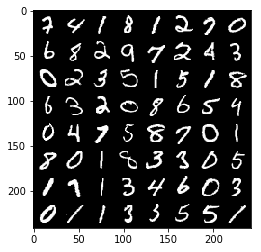

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [7]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


### Define a Conv Net


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [9]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [10]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [11]:
train(5)  # train 5 epochs should get you to about 97% accuracy

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294989
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.288002
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.290994
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.294875
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.233818
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.059136
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.815340
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.695658
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.451839
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.271922


/Users/jifu/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7418, Accuracy: 8225/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.446630
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.482599
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.372952
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.322183
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.301676
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.277521
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.246067
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.370679
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.341198

Test set: Average loss: 0.2421, Accuracy: 9288/10000 (93%)

Train Epoch: 2 [1536/60000 (3%)]	Loss: 0.265906
Train Epoch: 2 [7936/60000 (13%)]	Loss: 0.226089
Train Epoch: 2 [14336/60000 (24%)]	Loss: 0.183902
Train Epoch: 2 [20736/60000 (35%)]	Loss: 0.181725
Train Epoch: 2 [27136/60000 (45%)]	Loss: 0.202573
Train Epoch: 2 [33536/60000 (56%)]	Loss: 0.107020
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.267845
Train Epoch: 2 [46336/60000 (77%)]	Loss: 0.176087
Train Epoch: 2 [52736/60000 (88%)

## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [12]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [13]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()


Test set: Average loss: 2.3068, Accuracy: 964/10000 (10%)



### Define a training loop with model checkpointing

In [14]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [15]:
train_save(5, 500, 100)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.339287
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.300384
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.280099
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.257181
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.239247
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.027792
model saved to mnist-500.pth
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.628212
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.326480
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.003059
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.011925

Test set: Average loss: 0.6120, Accuracy: 8305/10000 (83%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.550870
model saved to mnist-1000.pth
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.390817
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.451650
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.326668
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.206300
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.305512
model saved to mnist-1500.pth
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.287842
Train Ep

In [16]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

model loaded from mnist-4690.pth

Test set: Average loss: 0.1145, Accuracy: 9656/10000 (97%)



## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [17]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [18]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
train(1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.256527
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.885628
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.478979
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.564524
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.458398
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.480895
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.611297
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.758554
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.378492
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.373563

Test set: Average loss: 0.1597, Accuracy: 9536/10000 (95%)



### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [20]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [22]:
train(1)  # training 1 epoch will get you to 93%!

Train Epoch: 0 [0/60000 (0%)]	Loss: 4.917601
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.737330
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.234772
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.393312
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.475781
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.475172
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.175355
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.399859
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.198737
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.402094

Test set: Average loss: 0.1730, Accuracy: 9483/10000 (95%)

